## Perceptron

In [ ]:
import warnings
import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, ClassifierMixin
warnings.filterwarnings('ignore')

### Base class implementation

In [1]:
class LinBase(BaseEstimator, ClassifierMixin):
    
    def __init__(self, coef=None, intercept=None, class_labels=None):
        self.coef_ = coef
        self.intercept_ = intercept
        self.class_labels_ = class_labels
    
    def margin(self, X, y):
        return y * (X.dot(self.coef_) + self.intercept_)
    
    def decision_function(self, X):
        return self.margin(X, np.ones(X.shape[0]))
    
    def predict_proba(self, X):
        b = self.margin(X, np.ones((X.shape[0])))
        return np.array([1 - 1 / (1 + np.exp(-b)), 1 / (1 + np.exp(-b))]).T
    
    def predict(self, X):
        results = np.sign(self.decision_function(X))
        results_mapped = [self.class_labels_[i] for i in 1 * (results > 0)]
        return results_mapped
    
    def get_params(self, deep=True): 
        return {"coef_": self.coef_, "intercept_": self.intercept_, "class_labels_": self.class_labels_}
    
    def set_params(self, parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
    
    def __str__(self):
        return f"{self.__class__.__name__}[w={self.coef_}, b={self.intercept_}]"

### Perceptron implementation

In [2]:
class Perceptron(LinBase):
    def __init__(self, break_time=1, **kwargs):
        super(Perceptron, self).__init__(**kwargs)
        self.break_time_ = break_time

    def fit(self, X, y):
        counter = 0
        i = 0
        n = 0
        k = 0
        m = X.shape[0]
        tic = time.time()
        toc = 0
        while n < m and toc - tic <= self.break_time_ * 3600:
            if self.margin(X[i], y[i]) <= 0:
                self.coef_ += y[i] * X[i]
                self.intercept_ += y[i]
                n = 0
                k += 1
            else:
                n += 1
            counter += 1
            i = counter % m
            toc = time.time()
        return toc - tic, k, self.coef_

### Perceptron implementation with gamma-margin

In [3]:
import copy

class GammaPerceptron(LinBase):
    def __init__(self, break_time=1, gamma=None, gamma_coef=None, gamma_intercept=None, **kwargs):
        super(GammaPerceptron, self).__init__(**kwargs)
        self.break_time_ = break_time
        self.gamma_ = gamma
        self.gamma_coef_ = gamma_coef
        self.gamma_intercept_ = gamma_intercept

    def fit(self, X, y):
        counter = 0
        i = 0
        n = 0
        k = 0
        m = X.shape[0]
        tic = time.time()
        toc = 0
        while n < m:
            if self.margin(X[i], y[i]) <= self.gamma_ * np.linalg.norm(self.coef_):
                self.coef_ += y[i] * X[i]
                self.intercept_ += y[i]
                n = 0
                k += 1
            else:
                n += 1
            if n == m and self.gamma_ is not None:
                self.gamma_ = np.min(self.margin(X, y))
                self.gamma_coef_ = copy.copy(self.coef_)
                self.gamma_intercept_ = copy.copy(self.intercept_)
                n = 0
                
            counter += 1
            i = counter % m
            toc = time.time()
            if toc - tic >= self.break_time_ * 3600:
                print("Error: Time is out, but gamma level is not reached.")
                break
        return toc - tic, k, self.coef_
    
    def gamma_predict(self, X):
        results = np.sign(X.dot(self.gamma_coef_) + self.gamma_intercept_)
        results_mapped = [self.class_labels_[i] for i in 1 * (results > 0)]
        return results_mapped

### Voted perceptron implementation

In [4]:
class VotedPerceptron(LinBase):
    def __init__(self, break_time=1, k_max=None, coef_list=[], intercept_list=[], c=[], **kwargs):
        super(VotedPerceptron, self).__init__(**kwargs)
        self.break_time_ = break_time
        self.k_max_ = k_max
        self.coef_list_ = coef_list
        self.intercept_list_ = intercept_list
        self.c_ = c

    def fit(self, X, y):
        counter = 0
        i = 0
        k = 0
        m = X.shape[0]
        tic = time.time()
        toc = 0
        self.coef_list_.append(self.coef_)
        self.intercept_list_.append(self.intercept_)
        self.c_.append(1)
        
        while k < self.k_max_ and toc - tic < self.break_time_ * 3600:
            if self.margin(X[i], y[i]) <= 0:
                self.coef_list_.append(self.coef_ + y[i] * X[i])
                self.intercept_list_.append(self.intercept_ + y[i])
                self.c_.append(1)
                
                self.coef_ = self.coef_list_[-1]
                self.intercept_ = self.intercept_list_[-1]
                k += 1
            else:
                self.c_[-1] += 1
            counter += 1
            i = counter % m
            toc = time.time()
        return toc - tic, k, self.coef_
            
    def predict(self, X):
        suma = 0
        for i, ic in enumerate(self.c_):
            suma += ic * np.sign((X.dot(self.coef_list_[i]) + self.intercept_list_[i]))
        return np.sign(suma)

### Averaged perceptron implementation

In [5]:
class AveragedPerceptron(LinBase):
    def __init__(self, break_time=1, k_max=None, coef_list=[], intercept_list=[], c=[], **kwargs):
        super(AveragedPerceptron, self).__init__(**kwargs)
        self.break_time_ = break_time
        self.k_max_ = k_max
        self.coef_list_ = coef_list
        self.intercept_list_ = intercept_list
        self.c_ = c

    def fit(self, X, y):
        counter = 0
        i = 0
        k = 0
        m = X.shape[0]
        tic = time.time()
        toc = 0
        self.coef_list_.append(self.coef_)
        self.intercept_list_.append(self.intercept_)
        self.c_.append(1)
        
        while k < self.k_max_ and toc - tic < self.break_time_ * 3600:
            if self.margin(X[i], y[i]) <= 0:
                self.coef_list_.append(self.coef_ + y[i] * X[i])
                self.intercept_list_.append(self.intercept_ + y[i])
                self.c_.append(1)
                
                self.coef_ = self.coef_list_[-1]
                self.intercept_ = self.intercept_list_[-1]
                k += 1
            else:
                self.c_[-1] += 1
            counter += 1
            i = counter % m
            toc = time.time()
        return toc - tic, k, self.coef_
            
    def predict(self, X):
        suma = 0
        for i, ic in enumerate(self.c_):
            suma += ic * (X.dot(self.coef_list_[i]) + self.intercept_list_[i])
        return np.sign(suma)

In [6]:
def plot_class(X, y, clf, gamma):
    [x1, x2] = np.meshgrid(np.linspace(np.nanmin(X[:, 0]), np.nanmax(X[:, 0]), 50), np.linspace(np.nanmin(X[:, 1]), np.nanmax(X[:, 1]), 50))
    y1 = clf.predict(np.array([x1.ravel(), x2.ravel()]).T)
    y1 = np.reshape(y1, (50, 50))
    plt.scatter(X[:, 0], X[:, 1], c=y)
    plt.contour(x1, x2, y1, [0, 1], colors='k')
    if gamma:
        y2 = clf.gamma_predict(np.array([x1.ravel(), x2.ravel()]).T)
        y2 = np.reshape(y2, (50, 50))
        plt.contour(x1, x2, y2, [0, 1], colors='g')       
    plt.show()

### Linear separation data

In [29]:
m, n = 30, 2
X = np.random.rand(m, n)
y = (X.dot([1, 1]) > 1) * 2 - 1

TIME: 0.006520271301269531, ITERATIONS = 16, MARGIN: [1.35042168 2.04028384]
SCORE: 1


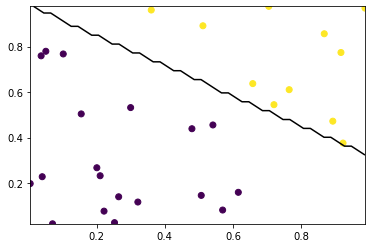

In [22]:
perceptron = Perceptron()
perceptron.set_params({"coef_": np.zeros(X.shape[1]), "intercept_": 0.0, "class_labels_": [-1, 1], "break_time_": 0.01})
t, i, w = perceptron.fit(X, y)
print(f"TIME: {t}(s), ITERATIONS = {i}, MARGIN: {w}")
unique, counts = np.unique(perceptron.predict(X) == y, return_counts=True)
if unique.shape[0] != 1:
    score = counts[1] / (np.sum(counts))
else:
    score = 1
print(f"SCORE: {score}")
plot_class(X, y, perceptron, False)

Error: Time is out, but gamma level is not reached.
TIME: 36.00218176841736, ITERATIONS = 1238791, MARGIN: [133819.88932849  71574.55448887]
SCORE: 1


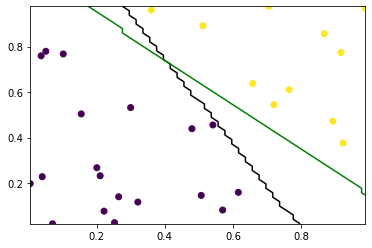

In [21]:
perceptron = GammaPerceptron()
perceptron.set_params({"coef_": np.zeros(X.shape[1]), "intercept_": 0.0, "class_labels_": [-1, 1], "gamma_": 0, "break_time_": 0.01})
t, i, w = perceptron.fit(X, y)
print(f"TIME: {t}(s), ITERATIONS = {i}, MARGIN: {w}")
unique, counts = np.unique(perceptron.predict(X) == y, return_counts=True)
if unique.shape[0] != 1:
    score = counts[1] / (np.sum(counts))
else:
    score = 1
print(f"SCORE: {score}")
plot_class(X, y, perceptron, True)

TIME: 18.006651878356934, ITERATIONS = 16, MARGIN: [1.35042168 2.04028384]
SCORE: 1


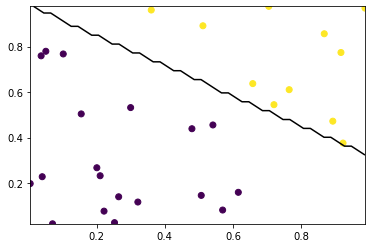

In [27]:
perceptron = VotedPerceptron()
perceptron.set_params({"coef_": np.zeros(X.shape[1]), "intercept_": 0.0, "class_labels_": [-1, 1], "k_max_": 100, "break_time_": 0.005})
t, i, w = perceptron.fit(X, y)
print(f"TIME: {t}(s), ITERATIONS = {i}, MARGIN: {w}")
unique, counts = np.unique(perceptron.predict(X) == y, return_counts=True)
if unique.shape[0] != 1:
    score = counts[1] / (np.sum(counts))
else:
    score = 1
print(f"SCORE: {score}")
plot_class(X, y, perceptron, False)

TIME: 36.012972354888916, ITERATIONS = 16, MARGIN: [1.35042168 2.04028384]
SCORE: 1


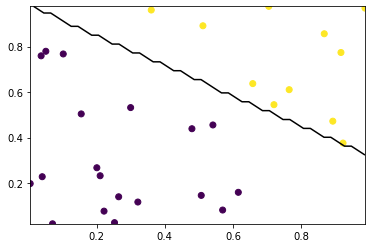

In [28]:
perceptron = AveragedPerceptron()
perceptron.set_params({"coef_": np.zeros(X.shape[1]), "intercept_": 0.0, "class_labels_": [-1, 1], "k_max_": 200, "break_time_": 0.01})
t, i, w = perceptron.fit(X, y)
print(f"TIME: {t}(s), ITERATIONS = {i}, MARGIN: {w}")
unique, counts = np.unique(perceptron.predict(X) == y, return_counts=True)
if unique.shape[0] != 1:
    score = counts[1] / (np.sum(counts))
else:
    score = 1
print(f"SCORE: {score}")
plot_class(X, y, perceptron, False)

### Nonlinear separation data

In [78]:
m, n = 30, 2
X = np.random.rand(m, n)
y = (X.dot([1, 1]) > 1) * 2 - 1
X += np.random.normal(0, 0.05, size=(m, n))

# from sklearn.datasets import make_blobs
# X, y = make_blobs(n_samples=30, centers=2, n_features=2)

TIME: 180.00091314315796, ITERATIONS = 2267488, MARGIN: [7.37537045 7.94721641]
SCORE: 0.9333333333333333


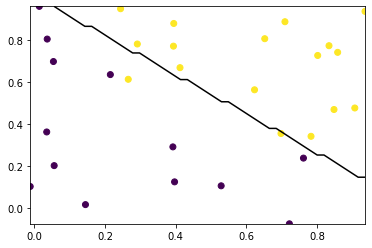

In [21]:
perceptron = Perceptron()
perceptron.set_params({"coef_": np.zeros(X.shape[1]), "intercept_": 0.0, "class_labels_": [-1, 1], "break_time_": 0.05})
t, i, w = perceptron.fit(X, y)
print(f"TIME: {t}(s), ITERATIONS = {i}, MARGIN: {w}")
unique, counts = np.unique(perceptron.predict(X) == y, return_counts=True)
if unique.shape[0] != 1:
    score = counts[1] / (np.sum(counts))
else:
    score = 1
print(f"SCORE: {score}")
plot_class(X, y, perceptron, False)

In [27]:
perceptron = GammaPerceptron()
perceptron.set_params({"coef_": np.zeros(X.shape[1]), "intercept_": 0.0, "class_labels_": [-1, 1], "gamma_": 0, "break_time_": 0.02})
t, i, w = perceptron.fit(X, y)
print(f"TIME: {t}(s), ITERATIONS = {i}, MARGIN: {w}")
unique, counts = np.unique(perceptron.predict(X) == y, return_counts=True)
if unique.shape[0] != 1:
    score = counts[1] / (np.sum(counts))
else:
    score = 1
print(f"SCORE: {score}")

Error: Time is out, but gamma level is not reached.
TIME: 72.000408411026, ITERATIONS = 430387, MARGIN: [7.81050832 8.43051637]
SCORE: 0.8666666666666667


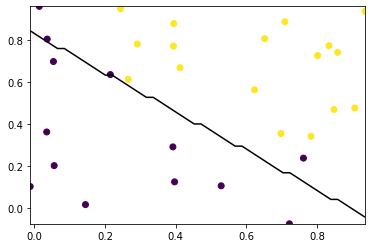

In [29]:
plot_class(X, y, perceptron, False)

TIME: 0.0, ITERATIONS = 200, MARGIN: [5.85133304 6.30730806]
SCORE: 0.9


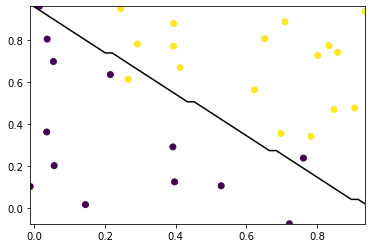

In [30]:
perceptron = VotedPerceptron()
perceptron.set_params({"coef_": np.zeros(X.shape[1]), "intercept_": 0.0, "class_labels_": [-1, 1], "k_max_": 200, "break_time_": 0.03})
t, i, w = perceptron.fit(X, y)
print(f"TIME: {t}(s), ITERATIONS = {i}, MARGIN: {w}")
unique, counts = np.unique(perceptron.predict(X) == y, return_counts=True)
if unique.shape[0] != 1:
    score = counts[1] / (np.sum(counts))
else:
    score = 1
print(f"SCORE: {score}")
plot_class(X, y, perceptron, False)

TIME: 0.0, ITERATIONS = 50, MARGIN: [2.4876317  2.51481762]
SCORE: 0.9


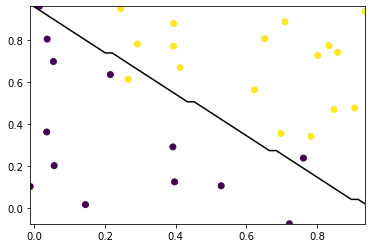

In [31]:
perceptron = AveragedPerceptron()
perceptron.set_params({"coef_": np.zeros(X.shape[1]), "intercept_": 0.0, "class_labels_": [-1, 1], "k_max_": 50, "break_time_": 0.02})
t, i, w = perceptron.fit(X, y)
print(f"TIME: {t}(s), ITERATIONS = {i}, MARGIN: {w}")
unique, counts = np.unique(perceptron.predict(X) == y, return_counts=True)
if unique.shape[0] != 1:
    score = counts[1] / (np.sum(counts))
else:
    score = 1
print(f"SCORE: {score}")
plot_class(X, y, perceptron, False)

### Sonar dataset

In [7]:
from scipy.io import arff
import pandas as pd

def fun(x):
    if type(x) == bytes:
        return str(x, encoding='utf-8')
    else:
        return x

data, meta = arff.loadarff("sonar.arff")
df = pd.DataFrame(data)
df = df.applymap(fun)
array = np.asarray(df).T 
X = np.array(array[:-1], dtype='float16').T
y = array[-1]
y = (y ==y[0]) * 2 - 1

In [64]:
perceptron = Perceptron()
perceptron.set_params({"coef_": np.zeros(X.shape[1]), "intercept_": 0.0, "class_labels_": [-1, 1], "break_time_": 1})
t, i, w = perceptron.fit(X, y)
print(f"TIME: {t}(s), ITERATIONS = {i} \nMARGIN: {w}")
unique, counts = np.unique(perceptron.predict(X) == y, return_counts=True)
if unique.shape[0] != 1:
    score = counts[1] / (np.sum(counts))
elif unique[0] == False:
    score = 0
else:
    score = 1
print(f"SCORE: {score}")

TIME: 369.3118484020233, ITERATIONS = 2733248 
MARGIN: [-3.95865562e+02 -6.66230927e+01  7.29583254e+02 -2.78609058e+02
  9.97491379e+01 -1.84330231e+02  2.25267578e+02  2.12468147e+02
 -3.18782249e+02  1.47332031e+02 -1.26226044e+02 -2.81252106e+02
  1.25180115e+02 -2.36051025e+01 -8.47157135e+01  1.53991425e+02
  1.67699402e+02 -2.06241089e+02  1.42944641e+02 -3.46832642e+02
  4.07667542e+02 -4.66360291e+02  3.52508026e+02 -3.54898438e+02
  1.58155029e+02  5.71906128e+01 -1.57599304e+02  6.63499298e+01
  8.72987366e+01 -4.00107819e+02  5.09363770e+02 -2.15425110e+02
 -7.48583679e+01  1.54719101e+02 -9.93968658e+01  1.14289246e+01
  1.85803345e+02 -2.47673340e+01 -2.11086334e+02  2.47868744e+02
 -3.80210876e+01 -7.87978821e+01 -4.28771515e+01 -7.16941833e+01
  1.15225128e+02 -2.24590530e+02 -2.14594269e+00 -4.32007187e+02
 -5.99106422e+02  2.80084408e+03 -7.66398397e+02 -1.80169555e+03
 -9.14270634e+02  1.21433323e+02 -4.24931419e+02  5.89108087e+02
  6.91525420e+02 -9.28226859e+02 -5

In [65]:
perceptron = GammaPerceptron()
perceptron.set_params({"coef_": np.zeros(X.shape[1]), "intercept_": 0.0, "class_labels_": [-1, 1], "gamma_": 0, "break_time_": 2.0})
t, i, w = perceptron.fit(X, y)
print(f"TIME: {t}(s), ITERATIONS = {i} \nMARGIN: {w}")
unique, counts = np.unique(perceptron.predict(X) == y, return_counts=True)
if unique.shape[0] != 1:
    score = counts[1] / (np.sum(counts))
elif unique[0] == False:
    score = 0
else:
    score = 1
print(f"SCORE: {score}")

Error: Time is out, but gamma level is not reached.
TIME: 7200.002749919891, ITERATIONS = 245404042 
MARGIN: [ -570462.13698006  -676551.14543915  -897843.59225368 -2137568.16514206
 -1852354.52906036  -805016.64795685    58335.76674271  -230554.87453461
 -3307125.0677948  -3799260.97418976 -5670451.58496094 -5297154.37026978
 -2583822.04826355   704883.36862183  2113199.91858101  2673436.13265991
  1574814.81567383   717465.72909546 -1090459.16351318 -1219269.8369751
 -1287486.14202881 -1218908.10357666 -1326780.8147583   -281146.94882202
  1440859.43740845  1758764.79675293    99974.06591797 -1520408.69494629
 -1042757.73794556  -813286.5715332   3634202.63830566   472957.80606079
   951560.39779663  1229011.39942932   907697.46662903  3914508.77571869
  2676734.13500977 -1810741.15228271 -1563154.28485107  2376787.6486969
     8177.38903809 -1344851.54049683 -2987517.89013672 -3941673.66143799
 -4170628.21565247 -2769736.60673714 -2580504.99224854 -2411435.78262329
 -1485755.0932312

In [12]:
perceptron = VotedPerceptron()
perceptron.set_params({"coef_": np.zeros(X.shape[1]), "intercept_": 0.0, "class_labels_": [-1, 1], "k_max_": 5000000000, "break_time_": 0.1})
t, i, w = perceptron.fit(X, y)
print(f"TIME: {t}(s), ITERATIONS = {i} \nMARGIN: {w}")

TIME: 360.01088094711304(s), ITERATIONS = 2661956 
MARGIN: [-3.95813082e+02 -5.19033356e+01  7.15170620e+02 -2.82448872e+02
  9.32568588e+01 -1.83524544e+02  2.25190567e+02  2.02862854e+02
 -2.93801888e+02  1.34377914e+02 -1.18738129e+02 -2.77176544e+02
  1.31588806e+02 -2.86402588e+01 -8.69268951e+01  1.55358856e+02
  1.68054474e+02 -2.12366455e+02  1.39014160e+02 -3.53572754e+02
  4.06787781e+02 -4.62291443e+02  3.59018921e+02 -3.50906219e+02
  1.47783325e+02  5.99152832e+01 -1.43998108e+02  6.68860321e+01
  8.21697083e+01 -3.96346375e+02  5.03916626e+02 -2.06089386e+02
 -8.64089355e+01  1.56495407e+02 -9.21853485e+01 -2.24063110e+00
  1.92082642e+02 -2.36604004e+01 -2.07574646e+02  2.46152802e+02
 -3.97384033e+01 -7.21643219e+01 -4.74605865e+01 -7.46529083e+01
  1.18417862e+02 -2.31610199e+02 -3.01994324e+00 -4.02274807e+02
 -6.06272835e+02  2.74660120e+03 -7.35459134e+02 -1.75545794e+03
 -9.07162467e+02  1.20572668e+02 -4.37716349e+02  5.65683259e+02
  6.77989960e+02 -9.34921251e+0

In [13]:
unique, counts = np.unique(perceptron.predict(X) == y, return_counts=True)
if unique.shape[0] != 1:
    score = counts[1] / (np.sum(counts))
elif unique[0] == False:
    score = 0
else:
    score = 1
print(f"SCORE: {score}")

SCORE: 0.9038461538461539


In [14]:
perceptron = AveragedPerceptron()
perceptron.set_params({"coef_": np.zeros(X.shape[1]), "intercept_": 0.0, "class_labels_": [-1, 1], "k_max_": 5000000000, "break_time_": 0.1})
t, i, w = perceptron.fit(X, y)
print(f"TIME: {t}(s), ITERATIONS = {i} \nMARGIN: {w}")
unique, counts = np.unique(perceptron.predict(X) == y, return_counts=True)
if unique.shape[0] != 1:
    score = counts[1] / (np.sum(counts))
elif unique[0] == False:
    score = 0
else:
    score = 1
print(f"SCORE: {score}")

TIME: 360.0013659000397(s), ITERATIONS = 2700147 
MARGIN: [-3.94375542e+02 -5.64242706e+01  7.17676855e+02 -2.82345707e+02
  9.09057541e+01 -1.81207970e+02  2.24399841e+02  2.05435738e+02
 -3.01634819e+02  1.41106415e+02 -1.18607758e+02 -2.80368042e+02
  1.31330688e+02 -2.98032837e+01 -8.63788300e+01  1.56722076e+02
  1.68506897e+02 -2.13708313e+02  1.42140930e+02 -3.56837891e+02
  4.09446472e+02 -4.64538879e+02  3.60193268e+02 -3.54230103e+02
  1.50808960e+02  5.71746216e+01 -1.45419128e+02  6.62020721e+01
  8.34309387e+01 -3.99265076e+02  5.05032837e+02 -2.08609589e+02
 -8.37929077e+01  1.55671890e+02 -9.46825104e+01  3.61236572e-01
  1.90028259e+02 -2.07967529e+01 -2.12126984e+02  2.49336884e+02
 -4.15083923e+01 -7.10707245e+01 -5.10497284e+01 -7.39490051e+01
  1.22102173e+02 -2.36494186e+02 -1.39053345e-01 -4.06501167e+02
 -6.04321426e+02  2.77758073e+03 -7.50834496e+02 -1.78096409e+03
 -9.11581177e+02  1.21857779e+02 -4.29435886e+02  5.75014274e+02
  6.85173264e+02 -9.30933871e+02